#### NOTEBOOK DE REPONSES #####
La version de python utilisé est la 3.7

In [1]:
# importation des differentes librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from sklearn.model_selection import (StratifiedShuffleSplit,
                                     GridSearchCV)
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, 
                             silhouette_score,
                             confusion_matrix,
                             matthews_corrcoef)
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (f1_score, 
                             accuracy_score,
                             make_scorer)
from scipy.stats import (kendalltau,
                         spearmanr)
%matplotlib inline
plt.style.use('ggplot')

### 1- Statistiques descriptives

#### 1. Description du jeu de données:
<i>Presentation des analyses et des éventuels retraitements</i>.
<br> <i>Conclusion sur les variables pertinentes à selectionner</i>.

In [2]:
# lecture du dataset
filename = 'data_v1.0 .csv'
data = pd.read_csv(filename, index_col='index')
# Visualisation  des données
data.head()

,Unnamed: 0,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,,,
0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [3]:
#avoir des infos sur les données
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 12 columns):
Unnamed: 0    20000 non-null int64
date          19909 non-null object
cheveux       19897 non-null object
age           19909 non-null float64
exp           19904 non-null float64
salaire       19905 non-null float64
sexe          19900 non-null object
diplome       19890 non-null object
specialite    19907 non-null object
note          19886 non-null float64
dispo         19894 non-null object
embauche      20000 non-null int64
dtypes: float64(4), int64(2), object(6)
memory usage: 2.0+ MB


In [4]:
# suppression de la premiere colonne non informative
data = data.drop(data.columns[0], axis=1)


In [5]:
#convertir dans un format date adequat
data['date'] = pd.to_datetime(data['date'],
                              format='%Y-%m-%d')
# informations generale sur le dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 11 columns):
date          19909 non-null datetime64[ns]
cheveux       19897 non-null object
age           19909 non-null float64
exp           19904 non-null float64
salaire       19905 non-null float64
sexe          19900 non-null object
diplome       19890 non-null object
specialite    19907 non-null object
note          19886 non-null float64
dispo         19894 non-null object
embauche      20000 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 1.8+ MB


In [6]:
print('valeurs manquantes par columnes:\n{}'.format(data.isnull().mean()*100))

valeurs manquantes par columnes:
date          0.455
cheveux       0.515
age           0.455
exp           0.480
salaire       0.475
sexe          0.500
diplome       0.550
specialite    0.465
note          0.570
dispo         0.530
embauche      0.000
dtype: float64


La plupart des variables explicatives contiennent des valeurs manquantes, toutes (<1%).
Plusieurs méthodes sont possibles. En effet, nous pouvons remplacer les valeurs manquantes par la moyenne, la médiane, enfin par regression des autres variables explicatives et enfin par le mode (pour les variables categorielles) et enfin les supprimer si elles sont en nombre restreint (<5% du dataset).
<br> Nous allons opter pour la dernière option et les supprimer de notre jeu de données.

#### Regardons le nombre de lignes du dataset supprimés en cas de non conservation des valeurs manquantes

In [7]:
clean_data = data.dropna(how='any').reset_index()
print('nombres de lignes manquantes: {}%'\
      .format(100-((len(clean_data)/len(data))*100)))

nombres de lignes manquantes: 4.89500000000001%


In [8]:
len(clean_data.query('note>100').index)

1401

#### Effectuons un peu de features engineering avec l'élément date

In [9]:
# créer un element annee
clean_data['year'] = clean_data['date'].dt.year
# creer un element mois
clean_data['month'] = clean_data['date'].dt.month
# créer un element jour
clean_data['day'] = clean_data['date'].dt.day
# creer un element week end
clean_data['week_day'] = clean_data['date'].dt.weekday


In [10]:
# description du jeu de donnees apres nettoyage
clean_data.describe()

,index,age,exp,salaire,note,embauche,year,month,day,week_day
count,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000
mean,9993.008990,34.998791,9.496662,34966.878713,75.184446,0.114558,2012.000473,6.534777,15.634877,3.004574
std,5771.344205,9.606263,3.012915,5005.208499,17.112102,0.318496,1.417166,3.453737,8.778311,2.006386
min,0.000000,-3.000000,-2.000000,14128.000000,8.680000,0.000000,2010.000000,1.000000,1.000000,0.000000
25%,4986.000000,29.000000,7.000000,31593.000000,63.730000,0.000000,2011.000000,4.000000,8.000000,1.000000
50%,9989.000000,35.000000,9.000000,34968.000000,75.110000,0.000000,2012.000000,7.000000,16.000000,3.000000
75%,14993.000000,41.000000,12.000000,38353.000000,86.670000,0.000000,2013.000000,10.000000,23.000000,5.000000
max,19999.000000,72.000000,23.000000,53977.000000,143.220000,1.000000,2014.000000,12.000000,31.000000,6.000000


La valeur maximum de la colonne <b>Note</b> contrairement à l'enoncé est de 143,
ce qui signifie qu'il y'a des notes plus grandes que 100.
<br> Ceci peut signifier une surperformance aux tests ou une erreur de mesure.
<br> Vu que l'enoncé precise que la note maximale est de 100 (vu que les tests sont notés)
sur 100, nous allons ramener l'ensemble des notes supérieures à 100 à 100.

In [11]:
cond = clean_data['note']>100
# rapporter les notes superieures à 100 à 100
clean_data.loc[cond, 'note'] = 100

Vu que le nombre de lignes à supprimer est lui inférieur sensiblement / <b>5%</b> de l'ensemble du dataset, on pourrait vraisemblablement les supprimer. Cependant, avant de considerer cette étape regardons l'impact d'une éventuel suppression sur le jeu de données.


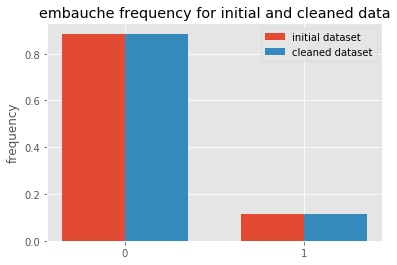

In [12]:
labels = data['embauche'].value_counts().index
data_embauche_stat = data['embauche'].value_counts()
data_clean_embauche_stat = clean_data['embauche'].value_counts()
#normalier les donnees
data_embauche_stat /= len(data['embauche'])
data_clean_embauche_stat /= len(clean_data['embauche'])

x = np.arange(len(labels))  # labels

width = 0.35  # largeur des bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data_embauche_stat, width, label='initial dataset')
rects2 = ax.bar(x + width/2, data_clean_embauche_stat, width, label='cleaned dataset')

# ajouter du texte, titre etc...
ax.set_ylabel('frequency')
ax.set_title('embauche frequency for initial and cleaned data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

<br> 0 represente le cas <b> pas d'embauche.</b> 
<br> 1 represente le cas <b> embauche. </b>
<br> Le fait de supprimer l'ensemble des valeurs manquantes de notre jeu de données n'affecte pas 
la distribution de la variable à prédire i.e embauche. <br> Nous allons donc procéder à cette suppression compte tenu aussi du faible nombre de valeurs manquantes (<5%).
<br>IL est vrai que nous aurions pu procéder à l'imputation de ces valeurs manquantes en utilisant diverses 
techniques/méthodes comme le remplacement par <b>la moyenne</b>, par <b>la médiane</b> ou le remplacement par <b>regression</b> des 
autres variables mais par peur d'introduire un biais quelconque dans le jeu de données au travers de ces méthodes,
nous allons supprimer les données.

#### Visualisation des variables numériques


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2531efd30>,
      dtype=object)

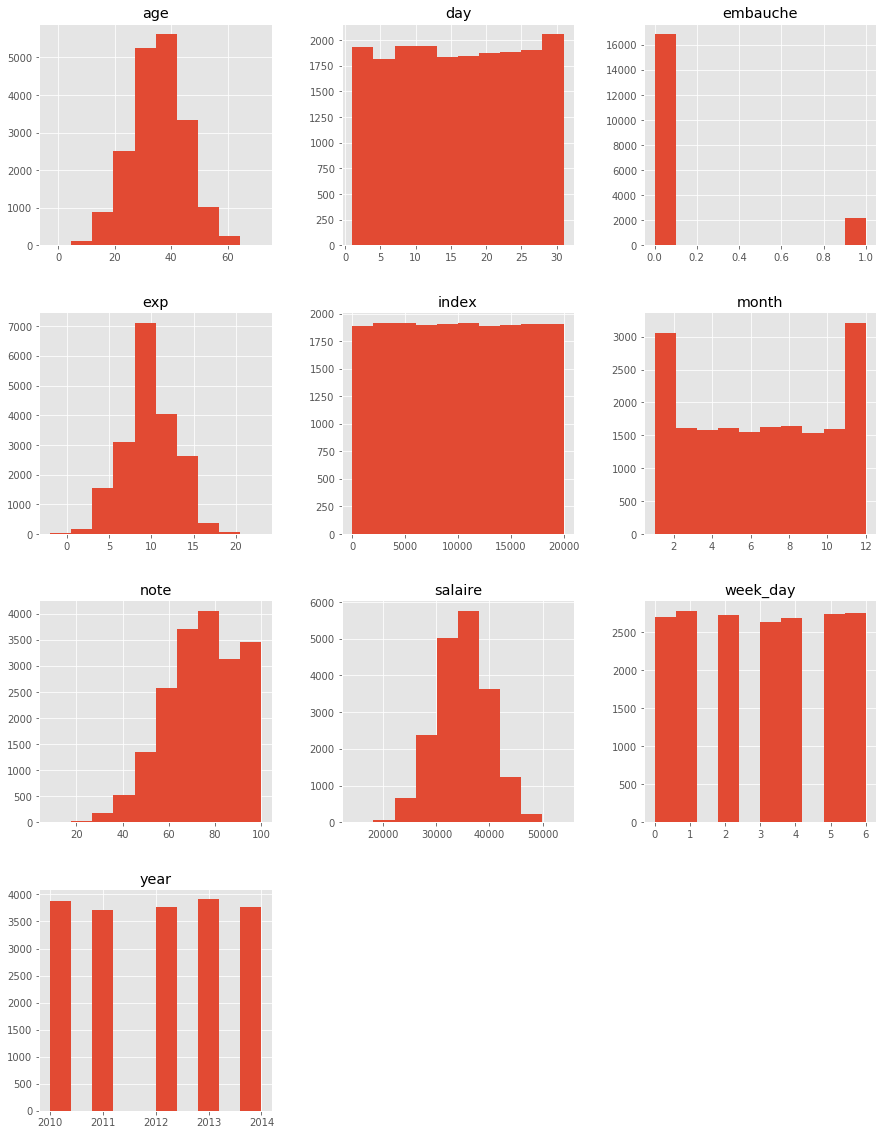

In [13]:
clean_data.hist(figsize=(15,20))

Les variables <b>age</b>,  <b>exp</b>, <b>note</b>, <b>salaire</b> ont une distribution quasi gaussienne.

#### Examinons la correlation lineaire entre les variables numériques du dataset
Les distributions etant gaussiennes pour la plupart (voir figure ci dessus),
nous pouvons utiliser le coefficient de correlation de <b>pearson</b>
pour detecter d'eventuels coefficients de correlation linéaire entre
les variables numériques.

In [14]:
clean_data.corr()['embauche']

index      -0.020974
age        -0.013513
exp         0.007384
salaire     0.002557
note        0.006605
embauche    1.000000
year        0.017818
month       0.007777
day        -0.009843
week_day    0.000085
Name: embauche, dtype: float64

Il n'y a rien de significatif à tirer de cette analyse sauf le fait que les autres variables numériques sont faiblement reliés à la variable cible <b>embauche</b>.
<br> Meme la <i>note</i> obtenue à l'exercice de la recherche d'or est très peu correlé à la potentielle embauche.
<br> Il y'a pour l'instant aucun pattern fixe se degageant des données.

### 2. Analyse des possibles dependances statistiques

#### 2.1 Y'a t'il une dependance statistiquement significative entre la specialité et le sexe?
<b> La specialité</b> et le <b> sexe</b> sont tous deux des variables de type categorielle.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons procéder à un test d'hypothèse du <b>khi-deux</b>.

In [15]:
X = "specialite"
Y = "sexe"

tableau_contengence = clean_data[[X,Y]].pivot_table(index=X,
                                                    columns=Y,
                                                    aggfunc=len,
                                                    margins=True,
                                                    margins_name="Total")


In [16]:
tableau_contengence

sexe,F,M,Total
specialite,,,
archeologie,1042,280,1322
detective,2409,1552,3961
forage,1899,2261,4160
geologie,2316,7262,9578
Total,7666,11355,19021


Calculons le tableau que l'on aurait du avoir en cas d'independance des deux evènements.

In [17]:
freq = tableau_contengence.loc['Total',:]/tableau_contengence.loc['Total','Total']

In [18]:
tableau_contengence_ind = tableau_contengence.copy()

In [19]:
tableau_contengence.loc['Total', 'Total']

for i in tableau_contengence.index:
    for j in tableau_contengence_ind.columns:
        if i!='Total' and j!='Total':
            tableau_contengence_ind.loc[i, j] = round((tableau_contengence_ind.loc['Total', j]/tableau_contengence_ind.loc['Total', 'Total'])*\
                                                      tableau_contengence_ind.loc[i, 'Total'], 1) 

In [20]:
tableau_contengence_ind

sexe,F,M,Total
specialite,,,
archeologie,532.8,789.2,1322
detective,1596.4,2364.6,3961
forage,1676.6,2483.4,4160
geologie,3860.2,5717.8,9578
Total,7666.0,11355.0,19021


In [21]:
carre_erreur_residuel_pondere = 0

for i in tableau_contengence_ind.index:
    for j in tableau_contengence_ind.columns:
        if i!='Total' and j!='Total':
            diff = tableau_contengence.loc[i, j]-tableau_contengence_ind.loc[i, j]      
            diff_carree = diff**2
            carre_erreur_residuel_pondere+= diff_carree/tableau_contengence_ind.loc[i, j]
            

La distribution Chi-deux demande (tout comme l’analyse de variance) le calcul du degré de liberté, car cette distribution varie de forme en fonction du degré de liberté du tableau croisé. Cependant, le calcul du degré de liberté ne dépend pas du nombre de sujets, mais plutôt du nombre de rangées (Ligne) et de colonnes (Colonne) dans votre tableau croisé.

Degré de liberté = (nombre de rangées – 1) X (nombre de colonnes – 1)  i.e
<br> Degré de liberté = (4-1)*(2-1)= <b>4</b>

Dans ce cas-ci, le degré de liberté de la distribution Chi-deux est de 1. Il suffit maintenant d'aller comparer cette statistique Chi-deux à la table de distribution Chi-deux paramétrée par le degré de liberté en fonction du niveau de signification choisi (probabilité de se tromper) à 5% i.e <b>p = 0.05</b>. Il sera alors possible ou non de rejeter l'hypothèse nulle d'absence de relation.
<br> La règle est la suivante :
<br>• Si le khi-carré calculé est inférieur au khi-carré théorique : indépendance
<br>• Si le khi-carré calculé est supérieur au khi-carré théorique : dépendance
#### TABLE  
<img src='image_2.png'>


le khi-carre calculé (2592.25) est supérieur au khi théorique (7.81) dans notre cas.
On peut donc vraisemblablement rejeter l'hypothèse nulle d'indépendance.
<br> Les deux variables sont donc statistiquement <b> dependantes </b>.
<br> Une implémentation de ce test est disponible sous <b> scipy </b> 
chi2_contingency

In [22]:
tableau_contengence = tableau_contengence.drop('Total', axis=1)
vtableau_contengence = tableau_contengence.drop('Total', axis=0)
chi2, pvalue, degrees, expected = chi2_contingency(tableau_contengence)
chi2, degrees, pvalue

(2592.2586573875888, 4, 0.0)

#### 2.2 Y'a t'il une dependance statistiquement significative entre la couleur des cheveux et le salaire demandé?
<b> La couleur des cheveux</b> est une variable categorielle et le <b> salaire</b> une variable numérique.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons procéder à un test <b> ANOVA (Analyse of Variance)</b> .

In [23]:
X = "cheveux" # qualitative
Y = "salaire" # quantitative


def eta_squared(x,y):
    """
    effectue un test ANOVA
    entre une variable numerique
    et une variable categorielle
    INPUT
    -x : variable du dataset 
    -y: variable du dataset
    OUTPUT
    - retourne le % de variance expliquée.
    
    """
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    # somme des carees totales
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    print('somme des carees totales {}'.format(SCT))
    # somme des carrees estimees
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    print('somme des carrees expliques {}'.format(SCE))
    return SCE/SCT
    
eta_squared(clean_data[X],clean_data[Y])

somme des carees totales 476491172405.1894
somme des carrees expliques 2065099532.8619144


0.004333972279985567

Tenant compte de la fonction <b>eta squared</b>, plus <b>SCE</b> est proche de <b> SCT</b>, plus la dependance statitisque entre
les deux variables est forte et vice versa.

#### 2.3 Y'a t'il une dependance statistiquement significative entre le nombre d'années d'experiences et la note de l'exercice ?
<b> Le nombre d'années d'experiences</b> est une variable quantitative et la <b> note de l'exercice</b> une variable numérique.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons calculer <b>le coefficient de correlation de pearson </b> pour ces variables (car leurs distribution semblent gaussiennes).
<b> Dans le cas contraire, on aurait pu utilisé les coefficients de <b>spearman</b> ou de <b>kendall-tau</b> basés sur le rang.

L'ensemble des variables explicatives comme visualisées plus haut semblent suivre une distribution gaussienne. On peut donc calculer le coefficient de correlation de pearson entre ces deux variables

In [24]:
corr = clean_data.corr()
print('correlation entre la note et le reste des variables \n{}'.format(corr['note'].sort_values(ascending=False)))

correlation entre la note et le reste des variables 
note        1.000000
day         0.013271
embauche    0.006605
index       0.004884
week_day    0.003710
year       -0.000723
age        -0.005773
exp        -0.012163
month      -0.012197
salaire    -0.442035
Name: note, dtype: float64


On remarque que les variables etudiées ne sont pas linéairement correlés (coefficient de correlation de pearson de -0.01)

Essayons de visualiser le resultat pour des algorithmes <b> non parametriques </b> tels que <b> spearman</b> et <b>kendall-tau</b>

In [25]:
kendall_result = kendalltau(clean_data['note'], clean_data['exp'])
spearman = spearmanr(clean_data['note'], clean_data['exp'])
print('coeff de spearmann {}'.format(spearman.correlation))
print('coeff de kendall_tau {}'.format(kendall_result.correlation))

coeff de spearmann -0.012396326869215461
coeff de kendall_tau -0.008661221353520253


Le resultat trouvé plus haut est donc confirmé. Les deux variables etudiés (la <b> note</b> et  l'<b>experience</b>) sont faiblement statistiquement liés.

### 2. Machine learning

#### 2.1 Choix de l'algorithme, specificités de parametrages
Pour le choix de l'algorithme, j'ai opté pour une méthode ensembliste ici <b> random forest </b>.
<br> Plusieurs raisons expliquent ce choix. Il s'agit d'abord d'une combinaison de plusieurs arbres de decisions entrainés sur des sous ensembles de features et des observations differentes pour fournir une reponse finale plus robuste.
<br> L'erreur commise par les classifieurs est lié d'une part aux données et d'autre part aux classifieurs que l'on choisi (<b> erreur ajouté</b>). Combiner plusieurs classifieurs permet de reduire l'erreur ajouté. Ce qui explique notre choix.
<br> Notre modèle dispose de plusieurs <b>hyperparametres</b>.
<br> <b>n_estimators</b> : nombre d'arbres de decision qui feront partie du random forest
<br> <b>max_features</b> : taille du sous ensemble aléatoire de features pour le meilleur split.


In [26]:
labels_to_keep = list(set(clean_data.select_dtypes(exclude=['number']))-set(['embauche', 'date']))
cat_features = clean_data[labels_to_keep]
num_features = clean_data.loc[:,['week_day', 'age', 'exp',
                                 'salaire', 'note', 'year', 
                                 'month', 'day']
                             ]
labels = clean_data.loc[:, 'embauche']

In [27]:
cat_dummies = pd.get_dummies(cat_features)
features = pd.concat([cat_dummies,num_features], axis=1)

# on va ici diviser le dataframe en 80% pour l'apprentissage et 20% pour le test
split = StratifiedShuffleSplit(n_splits=1, random_state=42)
for train_index, test_index in split.split(clean_data, clean_data['embauche']):
    train_set = features.loc[train_index, :]
    train_label = labels[train_index]
    test_set = features.loc[test_index, :]
    test_label = labels[test_index]
    

In [28]:
predictor = make_scorer(matthews_corrcoef)

def tree_param_selection(data_set, label_set, nfolds):
    """predire les metiers manquants
    Parametres
    ----------
    data_set : jeu de donnees ne contenant que les metiers manquants
    label_set : modele de prediction charge d'effectuer la prediction
    nfolds : nombre de groupe pour la cross validation
    Returns
    -------
    best_estimator : meilleur estimateur"""
    
    
    # Number of trees in random forest
    n_estimators = [50, 200, 500, 800]
    # Number of features to consider at every split
    max_features = [0.2, 0.8, "log2", "sqrt", None]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features
                  }
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=random_grid,
                               scoring=predictor,
                               cv=n_folds,
                               verbose=2,
                               n_jobs=-1
                               )
    grid_search.fit(data_set, label_set)
    print('best params {}'.format(grid_search.best_params_))
    print('best scores {}'.format(grid_search.best_score_))
    best_estimator = grid_search.best_estimator_
    return best_estimator

n_folds=3
tree_clf = tree_param_selection(train_set, train_label, n_folds)
# prediction on test_set
prediction_test_set = tree_clf.predict(test_set)
print(
    "correlation entre predictions et true labels: {}% \n".format(
        matthews_corrcoef(test_label, prediction_test_set)
    )
)

# calculer la matrice de confusion
confusion_matrice = confusion_matrix(
    test_label, prediction_test_set, labels=list(np
                                               .unique(test_label))
)
print('columnes matrice confusion {}'.format(list(np.unique(test_label))))
print("matrice de confusion \n {} ".format(confusion_matrice))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/cursedomonstro/anaconda3/envs/UdacityDataScience/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.1min finished


best params {'max_features': 0.8, 'n_estimators': 200}
best scores 0.5604046229864811
correlation entre predictions et true labels: 0.5824551770988882% 

columnes matrice confusion [0, 1]
matrice de confusion 
 [[1664   21]
 [ 118  100]] 


Une analyse de la matrice de correlation revèle que la classification des élements de la classe majoritaire (pas d'embauche) se passe très bien (seulement <b>peu d'éléments incorrectement classifiés</b>). 
<br> Cependant pour la classe <b>embauche</b> il y'a presqu'autant d'éléments correctement classifiés que d'éléments mal classifiés. Le système de classifieurs a plus de mal avec cette classe. Cela peut s'expliquer d'une part par le fait que les classes sont difficilement separable et d'autre part par le fait que l'on dispose de peu d'éléments de cette classe.

####  2.2 Variables les plus importantes de mon modèle selon le random forest

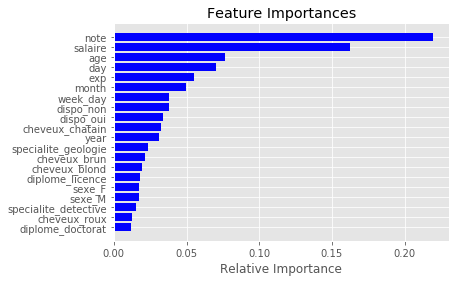

In [29]:
importances = tree_clf.feature_importances_
features_col = features.columns
indices = np.argsort(importances)[-20:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_col[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Comme on peut le voir sur le graphique, <b>la note</b>, <b>le salaire demandé</b>, l'<b>age</b> etc.. sont les variables les plus importantes servant à expliquer la columne <b>embauche</b>.
<br> Ce qui semble logique, vu que la note à l'exercice est supposé avoir un impact dans la selection. De plus il faut que le salaire demandé soit en adequation avec les moyens de la societé <b>OrFée</b>. Aussi, l'âge peut être un critère déterminant si l'entreprise recherche de jeunes candidats, le mois le jour ou la semaine s'il existe une periode de recrutement clé.

<b>2.3</b> Critère de performance utilisé

Le critère de performance etudié est <b>Matthews Correlation Coefficient</b>. Expliquons notre choix
<br> <b>L'accuracy</b> ne correspond pas ici comme métrique compte tenu de la repartition des classes (88.5% pour la classe <b>pas d'embauche</b> et <b>11.45% pour l'embauche</b>. En effet, un classifieur trivial qui predirait toujours 0 aurait un taux de bonne classification de 88% alors qu'il n'est pas efficace ici.
Aussi des metriques comme <b>la precision</b>, <b>le recall</b>, <b>f1_score</b> peuvent être utiliser ici. Re-definissons ces termes:
<br> <b>recall</b> : proportion d'éléments de la classe positive correctement classifiés. La classe positive representera ici le cas <b> embauche</b>.
<br><b>precision</b> : proportion d'éléments de la classe positive sur l'ensemble des élements de la classe positive
<br> <b>f1_score</b> : moyenne harmonique des deux elements precedents.
<br> Ces metriques sont interessantes dans le cas où nous avions une classe cible prioritaire à detecter (comme les cas de cancer) mais dans notre cas, il n y 'a aucune raison de privilégier une classe par rapport à un autre.
<br> Contrairement à ces métriques citées ci dessus, <b>le coefficient de correlation de matthews</b>, donne de la valeur aux deux classes (dans le cadre d'un classifieur binaire contrairement au f1_score et il est beaucoup plus fiable que <b>l'accuracy</b> qui est biaisé en cas de deséquilibre des classes.
<br> Il mesure ici la correlation entre les valeurs predites et les labels du test (en se basant sur la matrice de confusion)
$$MCC=\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$$
<br> <b>TP</b>: True Positive, <b>TN</b>: True Negative, <b>FP</b>: False Positive, <b>FN</b>: False Negative
<br> Des proprietés remarquables peuvent être deduite de cette formule:
<br> Si le classifieur est parfait, FP=FN=0 et MCC=1.
<br> Dans le cas où le classifieur est mauvais TP=TN=0, MCC=-1.

<b>2.4</b> Quelques pistes d'ameliorations du modèle.
<br> 1.Trouver plus de features (catacteristiques) en lien avec la variable à predire <b>embauche</b>.
<br> 2. Recueillir plus d'éléments de la variable <b>embauche</b>==1, ce qui nous permettrait de mieux effectuer la distinction entre les cas ou l'individu est embauché et ceux ou il ne l'est pas.